In [ ]:

import os
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from huggingface_hub import login, HfApi
from datasets import load_dataset, DatasetDict, concatenate_datasets, Dataset, Features, Value
from google.colab import files


In [ ]:
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

In [ ]:
def crop(
    dataset_dict,
    split="train",
    out_size=256,
    target_face_ratio=1.0,
    center_y_offset=0.0,
    scale_factor=1.1,
    min_neighbors=4
):
    """
    Crop faces với zoom cao để tập trung vào mắt, mũi, miệng, cằm
    """
    dataset = dataset_dict[split]

    face_cascade = cv2.CascadeClassifier(
        cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    )

    images_out = []
    labels_out = []

    for sample in tqdm(dataset, desc="Tight Zoom & Crop faces"):
        image = np.array(sample["image"])
        label = sample["label"]

        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        faces = face_cascade.detectMultiScale(
            gray,
            scaleFactor=scale_factor,
            minNeighbors=min_neighbors,
            minSize=(40, 40)
        )

        if len(faces) == 0:
            continue

        # lấy khuôn mặt lớn nhất
        x, y, w, h = max(faces, key=lambda box: box[2] * box[3])

        # tính hệ số zoom
        face_size = max(w, h)
        desired_face_size = target_face_ratio * out_size
        zoom_factor = desired_face_size / face_size

        # phóng to ảnh
        zoomed_image = cv2.resize(
            image, None,
            fx=zoom_factor,
            fy=zoom_factor,
            interpolation=cv2.INTER_CUBIC
        )

        # cập nhật toạ độ sau khi phóng to
        x_zoomed = int(x * zoom_factor)
        y_zoomed = int(y * zoom_factor)
        w_zoomed = int(w * zoom_factor)
        h_zoomed = int(h * zoom_factor)

        # tính tâm vùng cắt ảnh
        center_x = x_zoomed + w_zoomed // 2
        center_y = y_zoomed + h_zoomed // 2 + int(h_zoomed * center_y_offset)

        # tính biên crop
        half_size = out_size // 2
        crop_x1 = center_x - half_size
        crop_y1 = center_y - half_size
        crop_x2 = crop_x1 + out_size
        crop_y2 = crop_y1 + out_size

        # tinh chỉnh biên để không vượt quá ảnh
        h_img, w_img = zoomed_image.shape[:2]

        if crop_x1 < 0:
            crop_x1 = 0
            crop_x2 = out_size
        elif crop_x2 > w_img:
            crop_x2 = w_img
            crop_x1 = max(0, w_img - out_size)

        if crop_y1 < 0:
            crop_y1 = 0
            crop_y2 = out_size
        elif crop_y2 > h_img:
            crop_y2 = h_img
            crop_y1 = max(0, h_img - out_size)

        # tiến hành cắt gương mặt
        cropped_face = zoomed_image[crop_y1:crop_y2, crop_x1:crop_x2]

        # đảm bảo kích thước đầu ra
        if cropped_face.shape[0] != out_size or cropped_face.shape[1] != out_size:
            cropped_face = cv2.resize(cropped_face, (out_size, out_size))

        images_out.append(cropped_face)
        labels_out.append(label)

    return images_out, labels_out

In [ ]:
dataset = load_dataset("fcsn37/AI-image-detection-1m-faces")

1m_faces_91.zip:   0%|          | 0.00/3.33G [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset = DatasetDict({
    "train": load_dataset(
        "fcsn37/AI-image-detection-1m-faces",
        split="train[:5200]"
    )
})

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image'],
        num_rows: 5200
    })
})

In [ ]:
dataset = dataset.map(lambda _ : {'label' : 0})

Map:   0%|          | 0/5200 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5200
    })
})

In [ ]:
! rm -rf /content/onem-faces

In [ ]:
! mkdir /content/onem-faces

In [ ]:
images_out, labels_out = crop(
    dataset,
    split="train",
    out_size=256,
    target_face_ratio=1.2,
    center_y_offset=0.0,
    scale_factor=1.1,
    min_neighbors=4
)

Tight Zoom & Crop faces: 100%|██████████| 5200/5200 [1:20:22<00:00,  1.08it/s]


In [ ]:
for i, img in enumerate(tqdm(images_out, desc="Saving")):
    cv2.imwrite(
        f"/content/onem-faces/{i:06d}.jpg",
        cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    )

Saving: 100%|██████████| 5186/5186 [00:05<00:00, 963.15it/s]


In [ ]:
for i, sample in enumerate(dataset["train"]):
    img = sample["image"]
    img.save(f"{"/content/onem-faces"}/{i:06d}.jpg")

In [ ]:
! zip -r onem_5000.zip /content/onem-faces

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  adding: content/onem-faces/004568.jpg (deflated 1%)
  adding: content/onem-faces/004422.jpg (deflated 0%)
  adding: content/onem-faces/005141.jpg (deflated 1%)
  adding: content/onem-faces/005163.jpg (deflated 0%)
  adding: content/onem-faces/002995.jpg (deflated 1%)
  adding: content/onem-faces/000615.jpg (deflated 0%)
  adding: content/onem-faces/002367.jpg (deflated 1%)
  adding: content/onem-faces/004424.jpg (deflated 0%)
  adding: content/onem-faces/004582.jpg (deflated 0%)
  adding: content/onem-faces/002603.jpg (deflated 1%)
  adding: content/onem-faces/004472.jpg (deflated 1%)
  adding: content/onem-faces/000896.jpg (deflated 0%)
  adding: content/onem-faces/001987.jpg (deflated 0%)
  adding: content/onem-faces/002054.jpg (deflated 0%)
  adding: content/onem-faces/004598.jpg (deflated 1%)
  adding: content/onem-faces/004370.jpg (deflated 0%)
  adding: content/onem-faces/003466.jpg (deflated 0%)
  adding: content/onem-fa

In [ ]:
files.download('onem_5000.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
! zip -r fake_crop.zip /content/fake_crop

In [ ]:
files.download('fake_crop.zip')

Tight Zoom & Crop faces: 100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


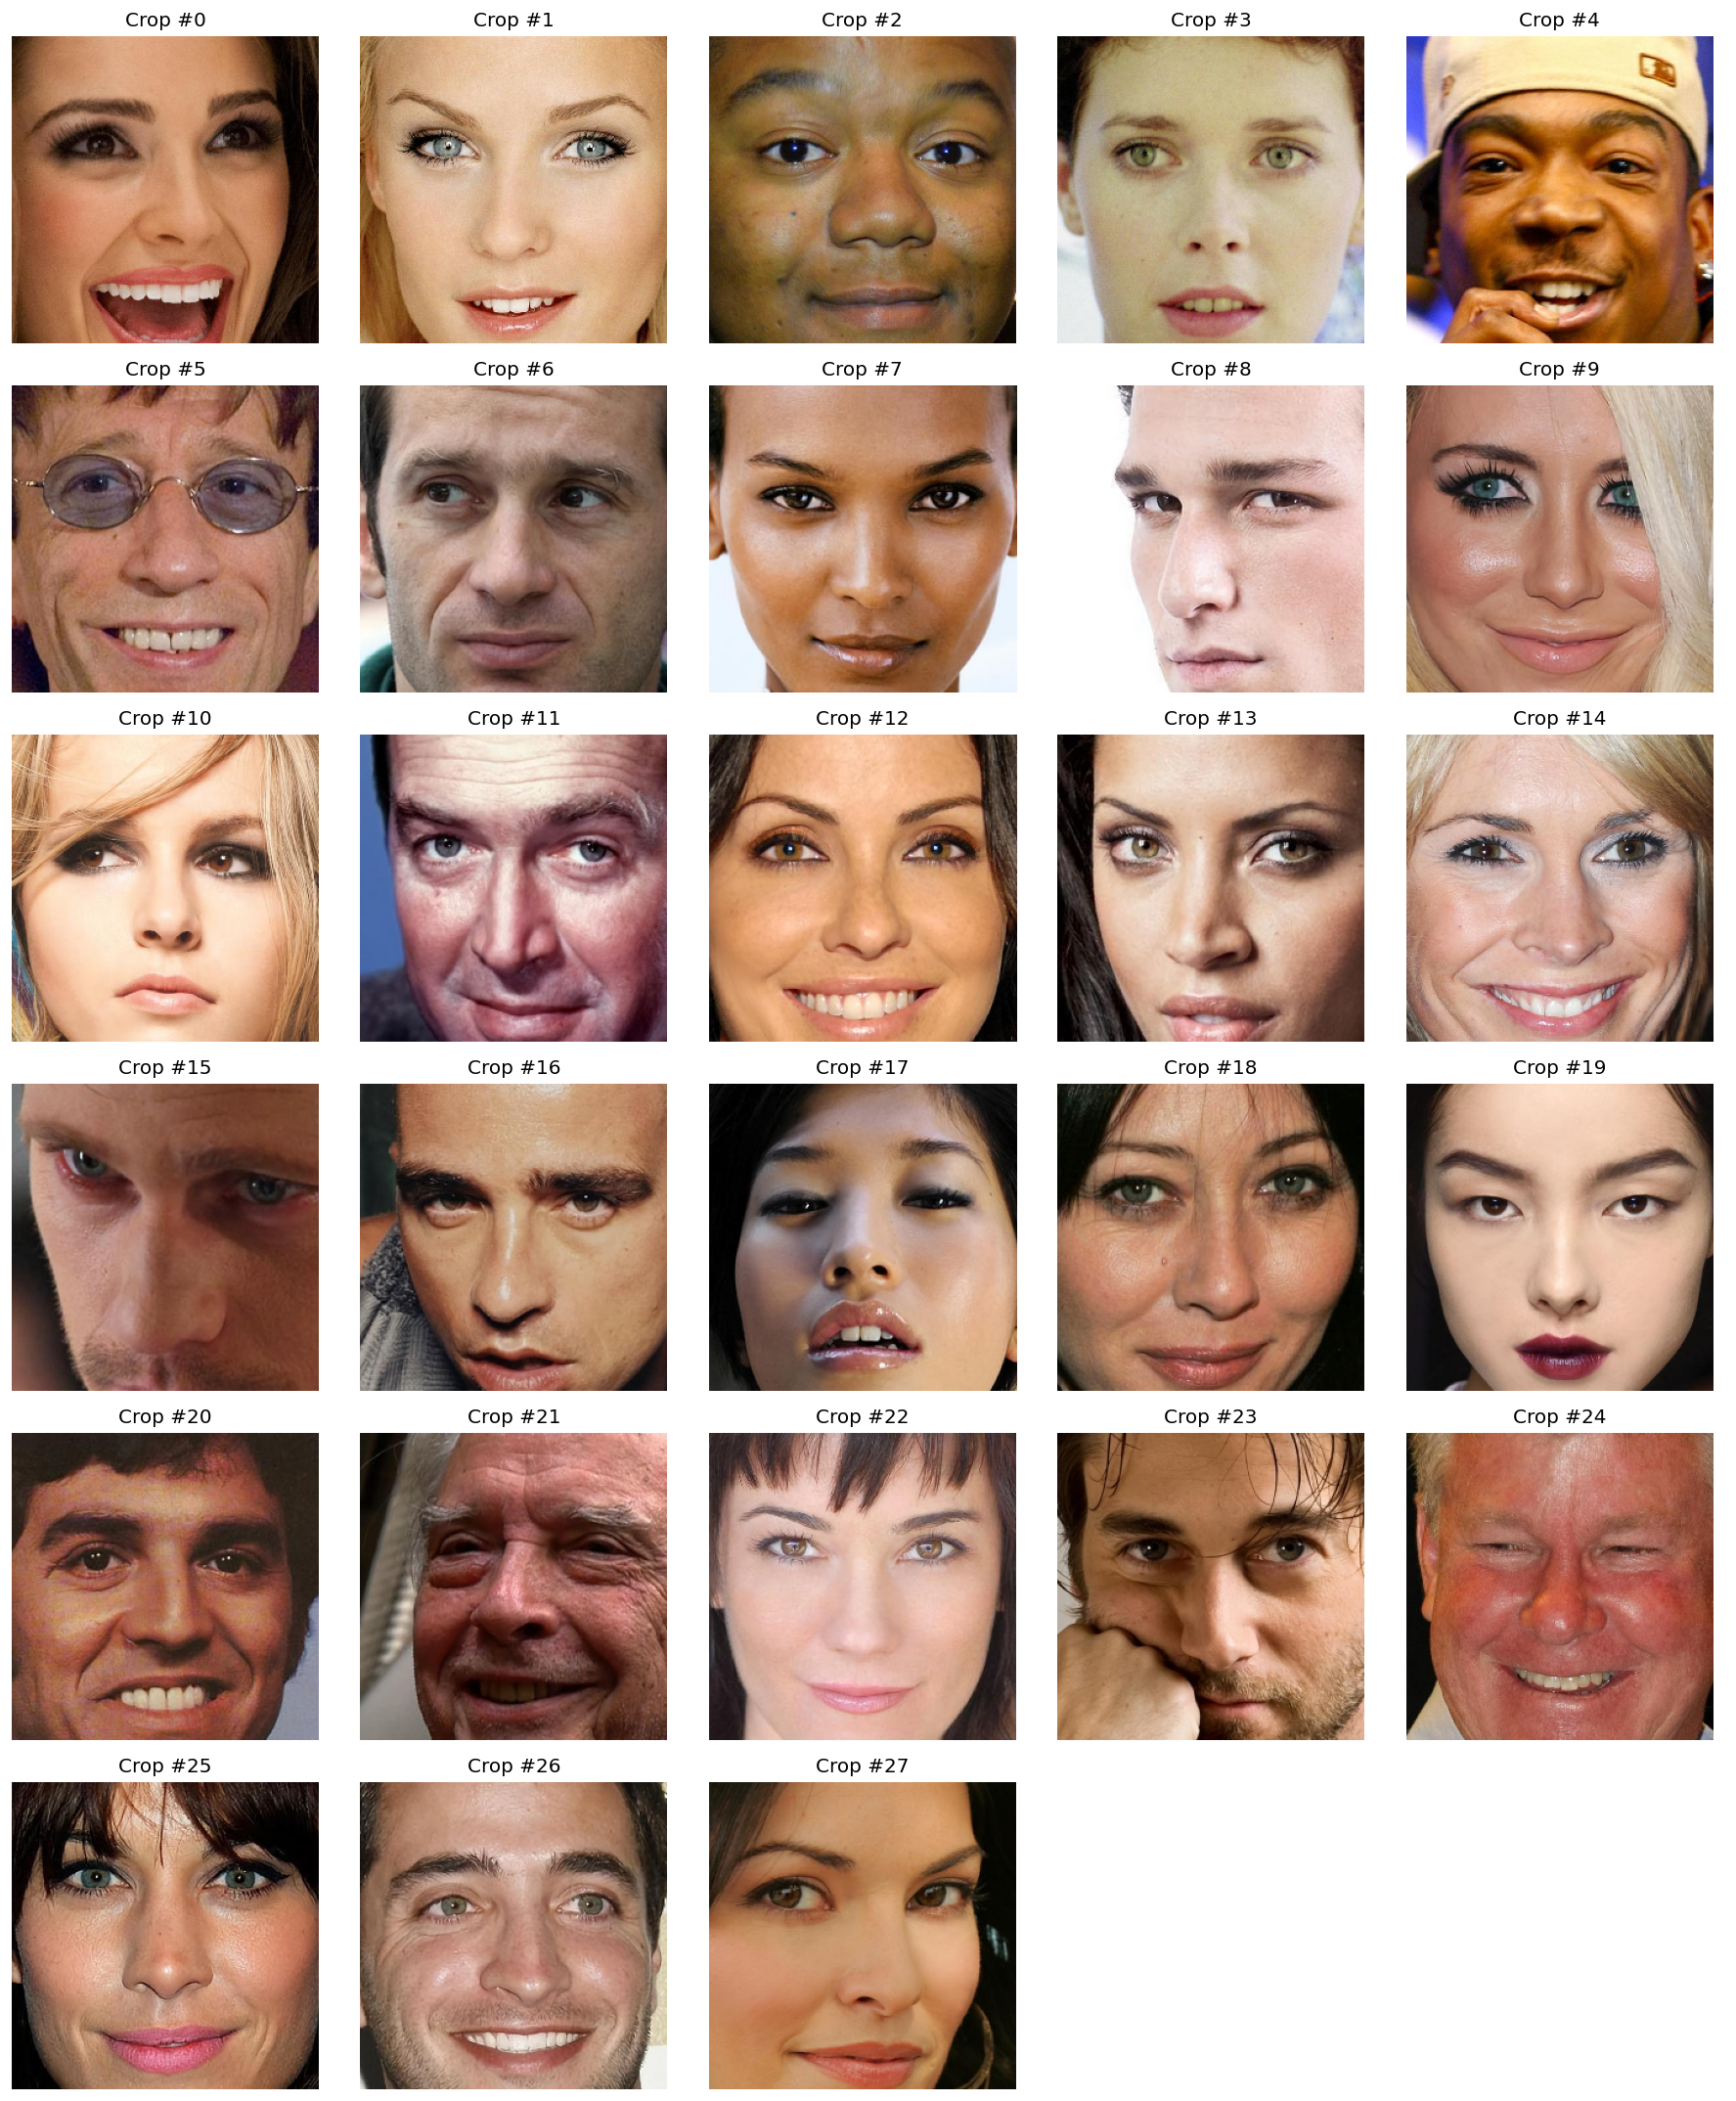

In [ ]:
# Lấy 10 ảnh đầu
subset_dataset = {
    "train": dataset["train"].select(range(30))
}

# Crop ảnh
images_out, labels_out = crop(
    subset_dataset,
    split="train",
    out_size=256,
    target_face_ratio=1.2,
    center_y_offset=0.0,
    scale_factor=1.1,
    min_neighbors=4
)

num_images = len(images_out)
cols = 5
rows = math.ceil(num_images / cols)

fig, axes = plt.subplots(
    rows, cols,
    figsize=(3 * cols, 3 * rows),
    dpi=120
)

axes = axes.flatten()

for i in range(num_images):
    axes[i].imshow(images_out[i])
    axes[i].set_title(f"Crop #{i}")
    axes[i].axis("off")

for j in range(num_images, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()